# Predictive Maintenance

These models were built from handcrafted datasets from https://www.unikie.com/en/stories/predictive-maintenance-tutorial-data-scientists/.

This project was done with the intention of practising building various ML models for Predictive Maintenance purposes and compare their performances.

The first dataset contains measurements from various sensors of the gadgets.

The seconds dataset contains the failure time and the id of the failed gadget.



## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, normalize
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Importing the Datasets
1. The first dataset contains data about the measurement time and other other parameters of the machine
2. The second dataset contains data about the failure time

In [2]:
df_measurements = pd.read_csv('measurements.csv', parse_dates=['measurement_time'])
df_measurements = df_measurements.sort_values(by = ['measurement_time'], ascending=[True])
df_measurements.head()

,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,Unnamed: 10,Unnamed: 11
0,2020-07-15,1,3,7,16.0,44.114437,NaN,NaN
336,2020-07-15,3,3,8,11.0,40.427740,NaN,NaN
168,2020-07-15,2,3,10,16.0,22.300000,NaN,NaN
840,2020-07-15,6,7,6,12.0,75.874521,NaN,NaN
672,2020-07-15,5,4,7,12.0,81.125342,NaN,NaN


In [3]:
df_failures = pd.read_csv('failures.csv', parse_dates=['failure_time'])
df_failures = df_failures.sort_values(by = ['failure_time'], ascending=[True])
df_failures.head()

,failure_time,gadget_id
52,2020-07-15 05:31:44.776014200,4
72,2020-07-15 05:48:58.383388460,5
53,2020-07-15 06:42:44.569051620,4
14,2020-07-15 07:11:50.319233260,2
39,2020-07-15 09:33:48.330967860,3


## Combine both datasets
Perform a left-join by matching failure time on nearest measurement time

In [4]:
df_combined = pd.merge_asof(df_measurements, df_failures, left_on = 'measurement_time', right_on =  'failure_time', 
                            by = 'gadget_id', direction = 'forward')

## Feature Engineering
1. Create a column that calculates the difference between the failure time and measurement time
2. Create a column that identifies failure that happened within an hour after measurement
3. Create a column that calculates 6 hour rolling standard deviation for the pressure
4. Create a column that calculates 6 hour rolling mean for the temperature

In [5]:
df_combined['time_to_fail'] = df_combined['failure_time'] - df_combined['measurement_time']
df_combined['fail_in_1h'] = np.where(df_combined['time_to_fail'] < pd.Timedelta(hours=1), 1, 0)
df_combined = df_combined.reset_index(drop=True)
df_combined = df_combined.sort_values(by=['gadget_id', 'measurement_time'], ascending=[True, True])

In [6]:
df_combined['temperature_6h_std'] = df_combined.groupby('gadget_id')['temperature'].rolling(6).std(ddof=0).reset_index(drop=True)
df_combined['pressure_6h_mean'] = df_combined.groupby('gadget_id')['pressure'].rolling(6).mean().reset_index(drop=True)

In [7]:
df_combined


,measurement_time,gadget_id,vibration_x,vibration_y,pressure,temperature,Unnamed: 10,Unnamed: 11,failure_time,time_to_fail,fail_in_1h,temperature_6h_std,pressure_6h_mean
0,2020-07-15 00:00:00.000,1,3,7,16.0,44.114437,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 09:56:03.974006640,0,NaN,NaN
7,2020-07-15 01:00:00.000,1,8,3,12.0,34.395177,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 08:56:03.974006640,0,3.453742,15.500000
13,2020-07-15 01:59:59.990,1,10,8,20.0,38.280705,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 07:56:03.984006640,0,3.803752,16.833333
18,2020-07-15 02:59:59.985,1,6,5,20.0,41.878215,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 06:56:03.989006640,0,3.679122,15.166667
25,2020-07-15 03:59:59.980,1,6,9,16.0,39.257268,NaN,NaN,2020-07-15 09:56:03.974006640,0 days 05:56:03.994006640,0,9.337838,13.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,2020-07-21 18:59:59.505,6,6,5,10.0,71.493668,NaN,NaN,2020-07-21 21:55:15.463450739,0 days 02:55:15.958450739,0,2.523321,14.750000
989,2020-07-21 19:59:59.505,6,6,4,15.0,68.088351,NaN,NaN,2020-07-21 21:55:15.463450739,0 days 01:55:15.958450739,0,4.888758,14.750000
992,2020-07-21 20:59:59.505,6,7,8,11.0,79.375957,NaN,NaN,2020-07-21 21:55:15.463450739,0 days 00:55:15.958450739,1,3.862833,15.000000
998,2020-07-21 21:59:59.505,6,6,7,16.0,80.754416,NaN,NaN,2020-07-21 22:09:51.002875980,0 days 00:09:51.497875980,1,5.541126,14.916667


## Prepare Training and Testing Dataset

In [8]:
X = ['vibration_y', 'pressure_6h_mean', 'temperature_6h_std']
y = 'fail_in_1h'
cols = X + [y]

df_to_split = df_combined.copy()
df_to_split = df_to_split.dropna(subset=cols)
df_to_split = df_to_split.reset_index(drop=True)


In [9]:
binner = KBinsDiscretizer(n_bins=10, encode='onehot-dense', strategy='kmeans')
df_bins = pd.DataFrame(binner.fit_transform(df_to_split[X]))

X = list(df_bins.columns)
cols = X + [y]

In [10]:
df_to_split = pd.concat([df_to_split, df_bins], axis=1)

df_train = df_to_split[df_to_split['gadget_id'].isin([1,2,3,4])].reset_index(drop=True).copy()
df_test = df_to_split[df_to_split['gadget_id'].isin([5,6])].reset_index(drop=True).copy()

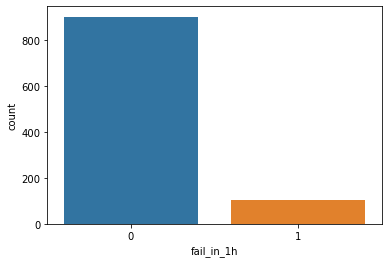

In [11]:
ax = sns.countplot(x="fail_in_1h", data=df_combined)

# Prediction Models

In [12]:
w0 = 1
w1 = 9
pos_label = 1

## Neural Network

In [13]:
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(10), random_state=1, max_iter=10000, activation='relu',
                   tol=0.00001)
nn.fit(df_train[X], df_train[y])
df_test['nn'] = nn.predict(df_test[X])

## Random Forest 

In [14]:
random_forest = RandomForestClassifier(min_samples_leaf=7, random_state=45, n_estimators=50, class_weight={0:w0, 1:w1})
random_forest.fit(df_train[X], df_train[y])
df_test['random_forest'] = random_forest.predict(df_test[X])

## Random Forest with Random Search Cross Validation

In [15]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# The degree of penalization for each class
class_weight = [{0: 1, 1: 8},{0: 1, 1: 9},{0: 1, 1: 10}]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'class_weight':class_weight}
pprint(random_grid)

{'bootstrap': [True, False],
 'class_weight': [{0: 1, 1: 8}, {0: 1, 1: 9}, {0: 1, 1: 10}],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [16]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(df_train[X], df_train[y])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.3min finished


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'class_weight': [{0: 1, 1: 8},
                                                         {0: 1, 1: 9},
                                                         {0: 1, 1: 10}],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                       

In [17]:
df_test['tuned_random_forest'] = rf_random.predict(df_test[X])

In [18]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'class_weight': {0: 1, 1: 9},
 'bootstrap': True}

## Random Forest with Grid Search with Cross Validation

In [19]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [90, 100, 110, 120, 130],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1, 2, 3],
    'min_samples_split': [1, 2, 3],
    'n_estimators': [1900, 2000, 2100],
    'class_weight': [{0: 1, 1: 7},{0: 1, 1: 8},{0: 1, 1: 9}]
}

# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)

In [20]:
# Fit the grid search to the data
grid_search.fit(df_train[X], df_train[y])

Fitting 3 folds for each of 405 candidates, totalling 1215 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   49.1s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  5.6min
[Parallel(n_jobs=-1)]: Done 1215 out of 1215 | elapsed:  6.9min finished


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True],
                         'class_weight': [{0: 1, 1: 7}, {0: 1, 1: 8},
                                          {0: 1, 1: 9}],
                         'max_depth': [90, 100, 110, 120, 130],
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [1900, 2000, 2100]},
             verbose=2)

In [21]:
df_test['gridsearch_random_forest'] = grid_search.predict(df_test[X])

## Logistic Regression Model

In [22]:
log_reg = LogisticRegression(class_weight={0:w0, 1:w1})
log_reg.fit(df_train[X], df_train[y])
df_test['log_reg'] = log_reg.predict(df_test[X])

## Linear Regression Model

## KNN 

In [24]:
def knn_weights(knn_y):
    return np.where(knn_y==1, w1, w0)

knn = KNeighborsClassifier(weights = knn_weights)
knn.fit(df_train[X], df_train[y])
df_test['knn'] = knn.predict(df_test[X])

## SVM

In [25]:
svm = SVC(class_weight={0:w0, 1:w1}, C=1, random_state=42, kernel='linear')
svm.fit(df_train[X], df_train[y])
df_test['svm'] = svm.predict(df_test[X])

## Naive Bayes

In [26]:
bayes = GaussianNB()
bayes.fit(df_train[X], df_train[y])
df_test['bayes'] = bayes.predict(df_test[X])

## Results

In [30]:
model_summary = []
models = ['random_forest', 'tuned_random_forest', 'gridsearch_random_forest','log_reg', 'knn', 'nn', 'svm', 'bayes']

for m in models:
    print(f"\n-----------\n{m}")
    try:
        precision = precision_score(df_test['fail_in_1h'], df_test[m], zero_division=0, pos_label=pos_label)
        recall = recall_score(df_test['fail_in_1h'], df_test[m], pos_label=pos_label)
        
        print(f"Precision: {precision}")
        print(f"Recall: {recall}")
        print(df_test[m].value_counts())

        model_summary.append({
            'model': m,
            'precision': precision,
            'recall': recall
        })

    except:
        print("Can't calculate score")


-----------
random_forest
Precision: 0.3106796116504854
Recall: 1.0
0    224
1    103
Name: random_forest, dtype: int64

-----------
tuned_random_forest
Precision: 0.3142857142857143
Recall: 0.6875
0    257
1     70
Name: tuned_random_forest, dtype: int64

-----------
gridsearch_random_forest
Precision: 0.3283582089552239
Recall: 0.6875
0    260
1     67
Name: gridsearch_random_forest, dtype: int64

-----------
log_reg
Precision: 0.3
Recall: 0.9375
0    227
1    100
Name: log_reg, dtype: int64

-----------
knn
Precision: 0.5
Recall: 0.1875
0    315
1     12
Name: knn, dtype: int64

-----------
nn
Precision: 0.4
Recall: 0.1875
0    312
1     15
Name: nn, dtype: int64

-----------
svm
Precision: 0.30303030303030304
Recall: 0.9375
0    228
1     99
Name: svm, dtype: int64

-----------
bayes
Precision: 0.30303030303030304
Recall: 0.9375
0    228
1     99
Name: bayes, dtype: int64


   gadget_id        measurement_time    0    1    2    3    4    5    6    7  \
0          5 2020-07-15 01:00:00.000  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0   
1          5 2020-07-15 01:59:59.990  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
2          5 2020-07-15 02:59:59.985  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
3          5 2020-07-15 03:59:59.980  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4          5 2020-07-15 04:59:59.975  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   ...   29  fail_in_1h  random_forest  tuned_random_forest  \
0  ...  0.0           0              0                    0   
1  ...  0.0           0              1                    1   
2  ...  0.0           0              0                    0   
3  ...  0.0           0              1                    0   
4  ...  0.0           1              1                    1   

   gridsearch_random_forest  log_reg  knn  nn  svm  bayes  
0                         0        0    0   0    0      0  
1                   

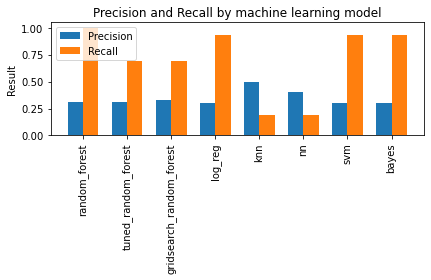

In [31]:
#PRINT RESULT DATAFRAME
print(df_test[['gadget_id', 'measurement_time'] + cols + models].head(5))

#CREATE IMAGE FOR MODEL COMPARISON
df_summary = pd.DataFrame(model_summary)

x = np.arange(len(df_summary['model']))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, df_summary['precision'], width, label='Precision')
rects2 = ax.bar(x + width/2, df_summary['recall'], width, label='Recall')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Result')
ax.set_title('Precision and Recall by machine learning model')
ax.set_xticks(x)
ax.set_xticklabels(df_summary['model'])
plt.xticks(rotation=90)
ax.legend()

fig.tight_layout()

Precision explains the percentage of failure predictions that were correct.

Recall explains the percentage of failures that the model captured.

Ideally we would want target for high precision and high recall. 

However, since these are dummy data, it included wicked fake patterns and randomness that would be difficult to capture without exact thresholds.



Nevertheless, the aim of this project is to practise implementing various models to the data and then, tune the models using Grid Search CV and to acquire improvise the performance. 